In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from collections import OrderedDict
from torch.autograd import Variable
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.utils.data

In [29]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def generateLatent(batch_size = 5,z_size = 200, noise=0.33):
    return Variable(torch.Tensor(batch_size, z_size).normal_(0, noise).cuda()).view(batch_size, z_size, 1,1,1)


In [17]:
# Creating a generator: Some latent vector to 3D voxel space 
# torch.nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
# (Din−1)∗stride[0]−2∗padding[0]+kernel_size[0]+output_padding[0]

class generator(nn.Module):
    def __init__(self, z_size=200, cube_size=32):
        super(generator, self).__init__()
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out
        
        


In [31]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 


class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])

        return out
        

In [38]:
#Training the system
num_epochs = 10
total_size = 5000
batch_size = 5
number_iterations = total_size / batch_size
voxels = np.load("voxels.npy")

train_loader = torch.utils.data.DataLoader(voxels, batch_size=5, shuffle=True, drop_last=True)

gen3d = generator()
gen3d.cuda()
dis3d = discriminator()
dis3d.cuda()
loss = nn.BCELoss()

for epoch in range(num_epochs):
    for batch_idx, data3d in enumerate(train_loader):
        z = generateLatent("batch_size"=batch_size)
        real_labels = torch.ones(args.batch_size).cuda()
        fake_labels = torch.zeros(args.batch_size).cuda()
        fake = gen3d(z)
        fake_labels_pred = dis3d(fake)
        real_labels_pred = dis3d(data3d)
        loss_fake = loss(fake_labels_pred, fake_labels)
        loss_real = loss(real_labels_pred, data3d)
        
        total_loss = loss_fake + loss_real
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
#Testing the Discriminator
voxels = np.load("voxels.npy")
print("Shape of the voxels", voxels.shape)
test_object = voxels[0]
print("Shape of the test object", test_object.shape)
dis3d = discriminator()
label = dis3d(Variable(torch.FloatTensor(test_object)))
print("Label value", label)

Shape of the voxels (5000, 32, 32, 32)
Shape of the test object (32, 32, 32)
Label value Variable containing:
(0 ,0 ,0 ,.,.) = 
  0.4958
[torch.FloatTensor of size 1x1x1x1x1]



Print Latent State shape torch.Size([1, 200, 1, 1, 1])
Shape of the fake torch.Size([1, 1, 32, 32, 32])
Displaying the object


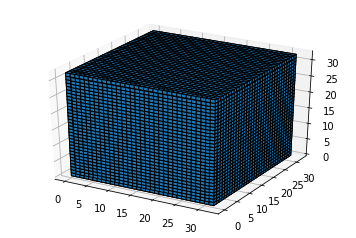

In [27]:
#Testing the Generator 
batch_size, z_size = 1, 200 
test_z = Variable(torch.Tensor(batch_size, z_size).normal_(0, 0.33).cuda()).view(batch_size, z_size, 1,1,1)
print("Print Latent State shape", test_z.shape)
gen3d = generator()
gen3d.cuda()
fake = gen3d(test_z)
print("Shape of the fake",fake.shape)
display3DObject(fake.squeeze().data.cpu().numpy())

Shape of the voxels (5000, 32, 32, 32)
Shape of the test object (32, 32, 32)


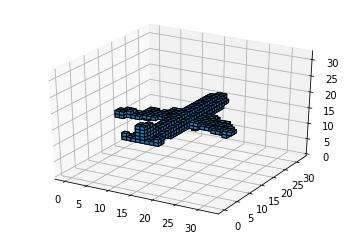

In [10]:
# Testing the Voxels
voxels = np.load("voxels.npy")
print("Shape of the voxels", voxels.shape)
test_object = voxels[0]
print("Shape of the test object", test_object.shape)

print("Displaying the object")
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(test_object, edgecolor='k')
plt.show()




